# Advanced Data Science &amp; Python for Finance (Spring 2020)
## Final Project:  Part 3 - Trading Strategy and Backtesting

-----

***FIN580-59305 Ruixin Zhang(individual work)***

Netid: ruixin3 UIN: 670003383

Master of Science in Finance, University of Illinois at Urbana-Champaign

-----
* [3.1. Use Intrinio API to pull the daily stock prices of all the constituents of your selected industry. Make sure that you have at least 100 trading days.](#3.1)
* [3.2 Select one company (stock) from your selected industry. In a short paragraph explain why you selected that particular company. For the company that you selected, create a long/short trading strategy. Make sure that you determine appropriate short and long trading windows and plot your strategy.](#3.2)
* [3.3 Backtest a 100,000 dollar long/short portfolio using Pandas and plot your portfolio value](#3.3)
* [3.4 Evaluate your trading strategy, calculate the portfolio sharpe ratio, maximum drawdown and Compound Annual Growth Rate (CAGR). In a short paragraph interpret the results.](#3.4)
* [3.5 Use backtrader to backtest a portfolio based on the industry that you selected. Make sure that there are executed trades and upload the plot that backtrader generated (use provided notebook)](#3.5)

=======================================================================================================================

## Packages and Settings

In [2]:
import intrinio_sdk
import configparser as cp

import statsmodels.api as sm
import numpy as np
import pandas as pd
import cufflinks as cf 
import matplotlib.pyplot as plt
cf.set_config_file(offline=True)
%matplotlib inline

### All the constituents of selected industry

In [3]:
sp1500_df = pd.read_csv("C:/Users/z/Desktop/FIN580 PYTHON/sp1500.csv",index_col = 0)
sp1500_df.head()

,ticker,price_close,pct_price_change_lastday,pct_pricechange_30day,pct_price_change_ytd,pct_price_change_12_month,price_earnings_ratio,price_bookvalue_ratio,marketcap_mm,revenue_mm,exchange,industry
company,,,,,,,,,,,,
3M Company,MMM,148.51,1.90,-0.32,-15.82,-16.84,17.10,8.42,85422.41,32348.00,NYSE,Industrial Conglomerates
A. O. Smith Corporation,AOS,44.79,3.42,11.36,-5.98,-10.95,21.51,4.47,7217.48,2881.40,NYSE,Building Products
"AAON, Inc.",AAON,48.94,0.74,-0.22,-0.95,3.36,47.63,8.31,2546.42,492.99,NasdaqGS,Building Products
AAR Corp.,AIR,18.20,9.05,-1.57,-59.65,-45.93,8.79,0.68,629.15,2218.20,NYSE,Aerospace and Defense
"Aaron's, Inc.",AAN,35.78,7.29,51.16,-37.35,-37.85,72.50,1.66,2417.71,4036.83,NYSE,Homefurnishing Retail


***Reminder: I have changed the original industry from Regional Banks to IT consulting and other Services since there are hundreds of companies from the original industry inside the S&P 1500 industry, which will make the diagram of my trading strategies in the end very messy.***

In [4]:
sp1500_rb = sp1500_df[sp1500_df['industry']=='IT Consulting and Other Services']
sp1500_rb = sp1500_rb.sort_values(['marketcap_mm'],ascending=False)[["ticker", "marketcap_mm","industry"]]
sp1500_rb.head()

,ticker,marketcap_mm,industry
company,,,
Accenture plc,ACN,120117.89,IT Consulting and Other Services
International Business Machines Corporation,IBM,109201.83,IT Consulting and Other Services
Cognizant Technology Solutions Corporation,CTSH,30899.56,IT Consulting and Other Services
"Leidos Holdings, Inc.",LDOS,14587.90,IT Consulting and Other Services
"Gartner, Inc.",IT,10931.09,IT Consulting and Other Services


In [5]:
## The tickers of all the companies from my chosen industry
selected_company = list(sp1500_rb['ticker'])
selected_company
len(selected_company)

12

<a id='3.1'></a>
##  3.1 Use Intrinio API to pull the daily stock prices of all the constituents of your selected industry

### API Setting

In [6]:
#Load API in secure mode
cfg = cp.ConfigParser()
cfg.read("C:/Users/z/Desktop/FIN580 PYTHON/credentials_Ruixin Zhang.cfg")

['C:/Users/z/Desktop/FIN580 PYTHON/credentials_Ruixin Zhang.cfg']

In [7]:
#Connect to API(sandbox API key)
API_KEY = cfg['intrinio']['app_key']
intrinio_sdk.ApiClient().configuration.api_key['api_key'] = API_KEY
security_api = intrinio_sdk.SecurityApi()

#### Intrinio API Request

In [8]:
start_date = '2019-11-01'
end_date = '2020-04-28'
frequency = 'daily'

In [9]:
dfs = []

for ticker in selected_company:
    next_page = ''
    response = security_api.get_security_stock_prices(ticker,
                                                      start_date = start_date,
                                                      end_date = end_date,
                                                      )
    df = [p.to_dict() for p in response.stock_prices]
    next_page = response.next_page
    if next_page != None:
        response = security_api.get_security_stock_prices(ticker,
                                                          start_date = start_date,
                                                          end_date = end_date,
                                                          next_page = next_page,
                                                          )    
        df.extend(p.to_dict() for p in response.stock_prices)
    df = pd.DataFrame.from_dict(df)
    df['secid'] = ticker
    dfs.append(df)

In [10]:
is_df = pd.concat(dfs)
is_df.index = pd.DatetimeIndex(is_df['date'])
is_df = is_df.drop('date', axis=1)
is_df.index.name = None

#SORT DATETIME INDEX
is_df = is_df.sort_index()
is_df.shape

(1464, 13)

**Check whether the number of observations in each company>100**

In [11]:
is_df.shape[0]/len(selected_company)

122.0

In [12]:
is_df.head()

,adj_close,adj_high,adj_low,adj_open,adj_volume,close,frequency,high,intraperiod,low,open,volume,secid
2019-11-01,224.610000,227.620000,221.720000,226.300000,181724.0,224.61,daily,227.62,False,221.7200,226.30,181724.0,CACI
2019-11-01,39.110000,39.470000,38.920000,39.470000,391487.0,39.11,daily,39.47,False,38.9200,39.47,391487.0,PRFT
2019-11-01,29.022221,29.051977,28.124675,28.258479,1864565.0,29.26,daily,29.29,False,28.3551,28.49,1864565.0,KBR
2019-11-01,74.313829,79.236984,73.043338,78.681144,281365.0,74.87,daily,79.83,False,73.5900,79.27,281365.0,MANT
2019-11-01,27.086795,27.106705,26.419829,26.469603,866433.0,27.21,daily,27.23,False,26.5400,26.59,866433.0,PRSP


In [13]:
is_df.to_csv("C:/Users/z/Desktop/FIN580 PYTHON/is_df.csv")

<a id='3.2'></a>
## 3.2 Select one company (stock) from your selected industry. In a short paragraph explain why you selected that particular company. For the company that you selected, create a long/short trading strategy. Make sure that you determine appropriate short and long trading windows and plot your strategy.

[VRTU]

If I find a company with large volatility, it would be easier to create some moving-average trading strategies since there is more change of stock price. After searching by Google, I decide to select VRTU as my target.

In [14]:
vrtu_df = is_df.loc[is_df['secid']=='VRTU']
vrtu_df.head()

,adj_close,adj_high,adj_low,adj_open,adj_volume,close,frequency,high,intraperiod,low,open,volume,secid
2019-11-01,38.62,38.63,37.21,37.52,190732.0,38.62,daily,38.63,False,37.21,37.52,190732.0,VRTU
2019-11-04,39.09,39.49,38.54,39.10,217591.0,39.09,daily,39.49,False,38.54,39.10,217591.0,VRTU
2019-11-05,39.52,39.64,38.75,39.14,323397.0,39.52,daily,39.64,False,38.75,39.14,323397.0,VRTU
2019-11-06,39.47,39.69,39.08,39.66,149026.0,39.47,daily,39.69,False,39.08,39.66,149026.0,VRTU
2019-11-07,39.78,40.35,39.35,39.80,311655.0,39.78,daily,40.35,False,39.35,39.80,311655.0,VRTU


In [15]:
##We only care about the (adjusted) closing stock price here
vrtu_df = vrtu_df[['secid','close','adj_close']]

**Determine Trading signal & Create Trading Orders**

In [16]:
vrtu_df['MA03'] = vrtu_df['close'].rolling(window = 3, min_periods = 1, center = False).mean()
vrtu_df['MA05'] = vrtu_df['close'].rolling(window = 5, min_periods = 1, center = False).mean() #week
vrtu_df['MA10'] = vrtu_df['close'].rolling(window = 10, min_periods = 1, center = False).mean() #half month
vrtu_df['MA20'] = vrtu_df['close'].rolling(window = 20, min_periods = 1, center = False).mean() #month

#MA03 vs MA05
vrtu_df['S0305'] = 0.0
vrtu_df['S0305'][3:] = np.where(vrtu_df['MA03'][3:]> vrtu_df['MA05'][3:], 1.0, 0.0)

vrtu_df['P0305'] = vrtu_df['S0305'].diff() 
vrtu_df['P0305'][0] = 1

#MA03 vs MA10
vrtu_df['S0310'] = 0.0
vrtu_df['S0310'][3:] = np.where(vrtu_df['MA03'][3:]> vrtu_df['MA10'][3:], 1.0, 0.0)

vrtu_df['P0310'] = vrtu_df['S0310'].diff() 
vrtu_df['P0310'][0] = 1

#MA05 vs MA10
vrtu_df['S0510'] = 0.0
vrtu_df['S0510'][5:] = np.where(vrtu_df['MA05'][5:]> vrtu_df['MA10'][5:], 1.0, 0.0)

vrtu_df['P0510'] = vrtu_df['S0510'].diff() 
vrtu_df['P0510'][0] = 1

#MA03 vs MA20
vrtu_df['S0320'] = 0.0
vrtu_df['S0320'][3:] = np.where(vrtu_df['MA03'][3:]> vrtu_df['MA20'][3:], 1.0, 0.0)

vrtu_df['P0320'] = vrtu_df['S0320'].diff() 
vrtu_df['P0320'][0] = 1

#MA05 vs MA20
vrtu_df['S0520'] = 0.0
vrtu_df['S0520'][5:] = np.where(vrtu_df['MA05'][5:]> vrtu_df['MA20'][5:], 1.0, 0.0)

vrtu_df['P0520'] = vrtu_df['S0520'].diff() 
vrtu_df['P0520'][0] = 1

In [17]:
vrtu_df.head()

,secid,close,adj_close,MA03,MA05,MA10,MA20,S0305,P0305,S0310,P0310,S0510,P0510,S0320,P0320,S0520,P0520
2019-11-01,VRTU,38.62,38.62,38.620000,38.620000,38.620000,38.620000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2019-11-04,VRTU,39.09,39.09,38.855000,38.855000,38.855000,38.855000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-05,VRTU,39.52,39.52,39.076667,39.076667,39.076667,39.076667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-06,VRTU,39.47,39.47,39.360000,39.175000,39.175000,39.175000,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2019-11-07,VRTU,39.78,39.78,39.590000,39.296000,39.296000,39.296000,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


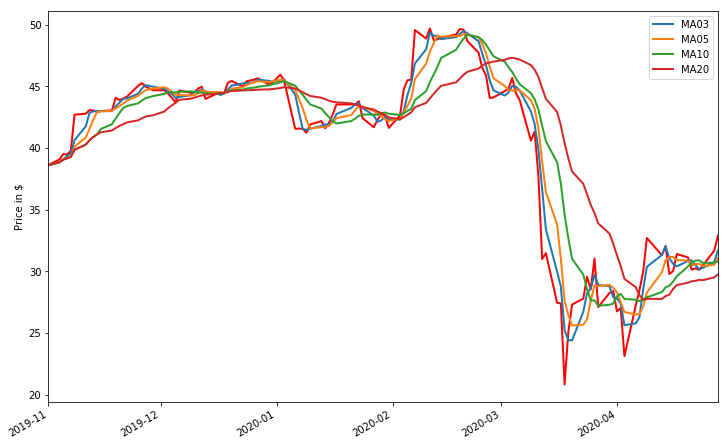

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111,  ylabel='Price in $')

vrtu_df['close'].plot(ax=ax1, color='r', lw=2.)
vrtu_df[['MA03','MA05','MA10','MA20']].plot(ax=ax1, lw=2.)
plt.show()

#### Choose MA03 vs MA20 as the strategy(Actually we are plotting the signals for a 3 day short and 20 day long strategy)

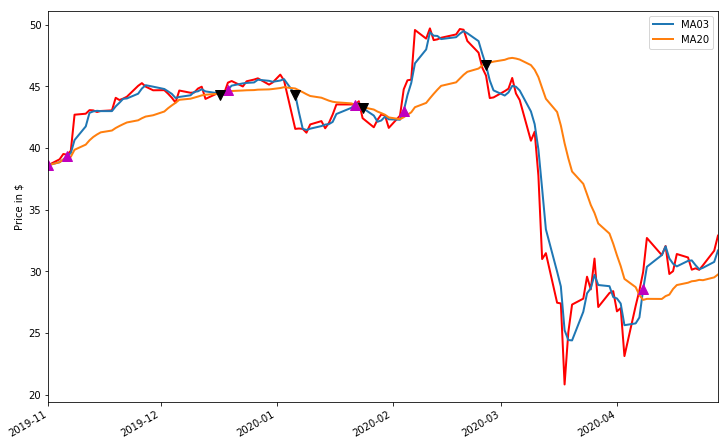

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111,  ylabel='Price in $')

vrtu_df['close'].plot(ax=ax1, color='r', lw=2.)
vrtu_df[['MA03','MA20']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(vrtu_df.loc[vrtu_df.P0320 == 1.0].index, 
         vrtu_df.MA03[vrtu_df.P0320 == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(vrtu_df.loc[vrtu_df.P0320 == -1.0].index, 
         vrtu_df.MA03[vrtu_df.P0320 == -1.0],
         'v', markersize=10, color='k')

plt.show()

<a id='3.3'></a>
## 3.3 Backtest a 100,000 long/short portfolio using Pandas and plot your portfolio value.

In [20]:
initial_capital= float(100000.0)
positions = pd.DataFrame(index = vrtu_df.index).fillna(0.0)
positions['VRTU'] = 5000 * vrtu_df['S0320']
portfolio = pd.DataFrame(index = positions.index).fillna(0.0)
pos_diff = positions.diff()

portfolio['holdings'] = positions.multiply(vrtu_df['adj_close'], axis=0)
portfolio['cash'] = initial_capital - (pos_diff.multiply(vrtu_df['adj_close'], axis=0)).sum(axis=1).cumsum()   
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change()
portfolio['signal'] = [ 'short' if i == 0 else 'long' for i in vrtu_df['S0320']]

portfolio.tail()

,holdings,cash,total,returns,signal
2020-04-22,151250.0,-43350.0,107900.0,0.005123,long
2020-04-23,150650.0,-43350.0,107300.0,-0.005561,long
2020-04-24,152500.0,-43350.0,109150.0,0.017241,long
2020-04-27,158400.0,-43350.0,115050.0,0.054054,long
2020-04-28,164500.0,-43350.0,121150.0,0.053020,long


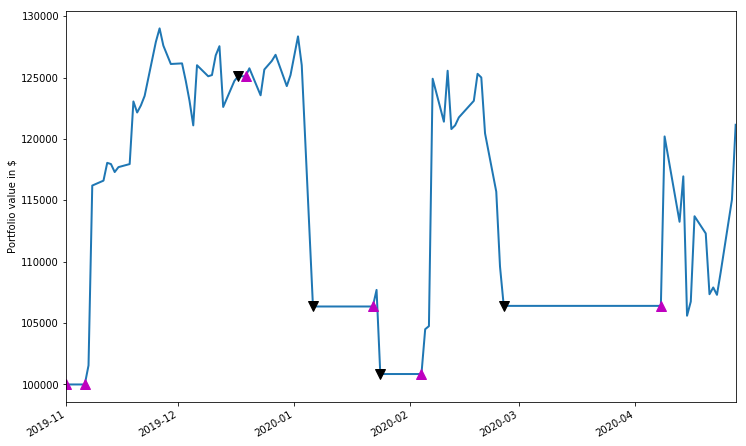

In [21]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

portfolio['total'].plot(ax=ax1, lw=2.)

# Plot the "buy" trades against the equity curve
ax1.plot(portfolio.loc[vrtu_df.P0320 == 1.0].index, 
         portfolio.total[vrtu_df.P0320 == 1.0],
         '^', markersize=10, color='m')

# Plot the "sell" trades against the equity curve
ax1.plot(portfolio.loc[vrtu_df.P0320 == -1.0].index, 
         portfolio.total[vrtu_df.P0320 == -1.0],
         'v', markersize=10, color='k')

plt.show()

<a id='3.4'></a>
## 3.4 Evaluate your trading strategy, calculate the portfolio sharpe ratio, maximum drawdown and Compound Annual Growth Rate (CAGR). In a short paragraph interpret the results.

#### Sharpe Ratio

In [22]:
returns = portfolio['returns']

# 100 Days Sharpe ratio
sharpe_ratio_100 = np.sqrt(100) * (returns.mean() / returns.std())
# annualized Sharpe ratio
sharpe_ratio_252 = np.sqrt(252) * (returns.mean() / returns.std())

print('100 Days Sharpe ratio:   '+ str(sharpe_ratio_100),'\nAnnualized Sharpe ratio: '+ str(sharpe_ratio_252))

100 Days Sharpe ratio:   0.6192378010827988 
Annualized Sharpe ratio: 0.9830095344453416


The typical Sharpe ratio of the S&P 500 index over a 10 year period is 0.5. Since 100 Days Sharpe ratio 0.62 for'MA03-MA20' strategy is better than that of Market return and market risk, we can conclude that a simple 'MA03-MA20' strategy for VRTU stock is a little better than investing S&P 500 index. However, the Covid-19 make the market uncertain higher than before, leading to lower Sharpe ratio during this period. As a result, this strategy can generate similar or better Sharpe ratio than Market. They're high enough for a simple moving-average strategy.Also the annualized sharpe ratio is pretty promising.

Efficient Market Hypothesis(EMH) indicates that there should not be any excess return based on past information. However, our strategy indicates that we can generate a better return with moving-average strategy, so EMH doesn't work.

#### Maximum Drawdown

In [23]:
max_window = 12

rolling_max = vrtu_df['adj_close'].rolling(max_window, min_periods=1).max()
daily_drawdown = vrtu_df['adj_close']/rolling_max - 1.0

max_daily_drawdown = daily_drawdown.rolling(max_window, min_periods=1).min()

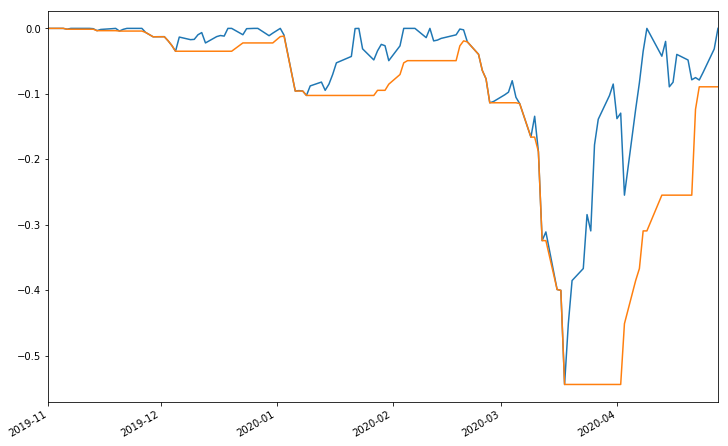

In [24]:
fig = plt.figure(figsize=(12,8))

daily_drawdown.plot()
max_daily_drawdown.plot()

plt.show()

The maximum drawdown is at the end of February and March. The drawdown on March are mostly caused by COVID-19. Although we know the IT and service industry performance is bettern than other industries, the decrease is still pretty large.

##### CAGR of stock performance

In [25]:
days = (vrtu_df.index[-1] - vrtu_df.index[0]).days
cagr = ((((vrtu_df['adj_close'][-1]) / vrtu_df['adj_close'][1])) ** (365.0/days)) - 1

print(cagr)

-0.29638905444199537


The CAGR of VRTU stock price is -29.64%.  In contrast, the returns of our portfolio is better than it. Our strategy looks effective in this period. However, we should apply this strategy in other period to backtesting if the strategy also work. Also, the current market situation is not usual, so we are not sure whether the strategy is useful any periods or not.

=====================================================================================================================

<a id='3.5'></a>
## 3.5 Use backtrader to backtest a portfolio based on the industry that you selected. Make sure that there are executed trades and upload the plot that backtrader generated (use provided notebook)

<a id='backtrader'></a>

# Backtrader 

**Strategy Overview**

Given current market conditions and increase in volatility we may be able to take advantage of a simple moving average pair with rsi mean reversion on a portfolio of SP1500 stocks. 
 
**Strategy**

SP1500 IT ans Service stocks will rank by 3-day moving average. From that rank we will take the lower 10 stocks and rank them by their 20-day relative strength indicator (RSI) to determine what stocks may be oversold.

Top two with highest RSI will be candidate for a buy and sell previous positions rebalance every Monday.

**Trade Management and Position Sizing**

* Position size buy/sell 100 shares at a time without 
* Backtrader will reject order if not enough funds

## Packages and Settings

In [26]:
import backtrader as bt

## Data Preparation: Backtrader Data format

In [27]:
is_df = pd.read_csv("C:/Users/z/Desktop/FIN580 PYTHON/is_df.csv", index_col= 0)

In [28]:
is_df.columns

Index(['adj_close', 'adj_high', 'adj_low', 'adj_open', 'adj_volume', 'close',
       'frequency', 'high', 'intraperiod', 'low', 'open', 'volume', 'secid'],
      dtype='object')

In [29]:
is_df['secid'].unique()

array(['CACI', 'PRFT', 'KBR', 'MANT', 'PRSP', 'SAIC', 'IT', 'LDOS',
       'CTSH', 'IBM', 'ACN', 'VRTU'], dtype=object)

**Create a new dataframe for backtrader**

In [30]:
bt_data = is_df[['adj_open', 'adj_high', 'adj_low', 'adj_close', 'adj_volume', 'secid']]

**Change the name of the columns to work with backtrader**

In [31]:
bt_data = bt_data.rename(columns={'adj_open':'open', 'adj_high':'high', 'adj_low':'low',
                                  'adj_close':'close', 'adj_volume':'volume', 'secid':'name'})
bt_data.index.name = None
bt_data.head()

,open,high,low,close,volume,name
2019-11-01,226.300000,227.620000,221.720000,224.610000,181724.0,CACI
2019-11-01,39.470000,39.470000,38.920000,39.110000,391487.0,PRFT
2019-11-01,28.258479,29.051977,28.124675,29.022221,1864565.0,KBR
2019-11-01,78.681144,79.236984,73.043338,74.313829,281365.0,MANT
2019-11-01,26.469603,27.106705,26.419829,27.086795,866433.0,PRSP


**Save the complete prepared dataset with industry constituents stock prices**

In [32]:
bt_data.to_csv("C:/Users/z/Desktop/FIN580 PYTHON/bt_is.csv")

**We also need to save each individual stock price as separate file**

In [33]:
constituents = bt_data['name'].unique()

In [35]:
# Each stock price from btdata is saved to a folder called historical_stock_price
for stock in constituents:
     bt_data[bt_data['name'] == stock].to_csv("C:/Users/z/Desktop/FIN580 PYTHON/historical_stock_price/" + stock + ".csv")

## Creating a Backtrader Strategy 

**Read the constituents stock data into backtrader**

In [36]:
bt_data = pd.read_csv("C:/Users/z/Desktop/FIN580 PYTHON/bt_is.csv",index_col = 0 )
constituents = bt_data.name.unique()
len(constituents)

12

**Strategy Class**

In [165]:
class MomentumStrategy(bt.Strategy):
    params = dict( 
        num_universe = 10, # Number of Industry Constituents ####This should be how many stocks we want to take from MA list
        num_positions = 2, # Set the number of position to hold at any given time
        when = bt.timer.SESSION_START,
        weekdays = [5],
        weekcarry = True,
        rsi_period = 20, # Relative Strength Index Periods
        sma_period = 3 # Moving Average Periods
    )
    
    def __init__(self):
        self.inds = {}
        self.rsi = {}
        
        self.securities = self.datas[1:]
        for s in self.securities:
            self.inds[s] = {}
            self.inds[s]['sma'] = bt.ind.SMA(s, period = self.p.sma_period)
            self.inds[s]['sma'].plotinfo.plot = False
            self.inds[s]['rsi'] = bt.ind.RSI(s, period = self.p.rsi_period)
            self.inds[s]['rsi'].plotinfo.plot = False
        
        self.add_timer(
            when = self.p.when,
            weekdays = self.p.weekdays,
            weekcarry = self.p.weekcarry
        )
        
    def notify_timer(self, timer, when, *args, **kwargs):
            self.rebalance()
        
    def notify_trade(self, trade):
        if trade.size == 0:
            print("DATE:", trade.data.datetime.date(ago=0),
                  " TICKER:", trade.data.p.name, 
                  "\tPROFIT:", trade.pnlcomm)

    def rebalance(self):
        
        rankings = list(self.securities)
        
        rankings.sort(
            key = lambda s: self.inds[s]['sma'][0],
            reverse = False
        )
        
        rankings = rankings[:self.p.num_universe] #######Take the Top 10 worst
        
        rankings.sort(
            key = lambda s: self.inds[s]['rsi'][0],
            reverse = True
        )

        # position size short
        pos_size = -1 / self.p.num_positions 

        # Sell when ranking
        for i, d in enumerate(rankings):
            if self.getposition(d).size:
                if i > self.p.num_positions: #####if > 2
                    self.close(d)

        # Buy and rebalance stocks with remaining cash
        for i, d in enumerate(rankings[:self.p.num_positions]):
            self.order_target_percent(d, target = pos_size)
            

**Cerebro Parameters**

In [166]:
starcash = 100000

In [167]:
cerebro = bt.Cerebro()
cerebro.broker.setcash(starcash)
cerebro.broker.setcommission(commission=0.0)

**Feed data to backtrader**

In [168]:
first_stock = True
for stock in constituents:
    # Load the each stock price data from the btdata folder 
    filename = "C:/Users/z/Desktop/FIN580 PYTHON/data_part3/" + stock + ".csv"
    data = bt.feeds.GenericCSVData(
        dataname = filename,
        dtformat = ('%Y-%m-%d'),
        datetime = 0,
        high = 2,
        low = 3,
        open = 1,
        close = 4,
        volume = 5,
        openinterest = -1,
        name = stock)
    if first_stock:
        data0 = data
        data.plotinfo.sameaxis = False
        data.plotinfo.plotylimited = True
        first_stock = False
    else:
        data.plotinfo.plotmaster = data0
        data.plotinfo.subplot = False
        data.plotinfo.sameaxis = False
        data.plotinfo.plotylimited = True
    cerebro.adddata(data, name = stock)

In [169]:
cerebro.addstrategy(MomentumStrategy)

0

In [170]:
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)

In [171]:
# When run section you should see trades excuted
# If there are no trades excuted modifed the RSI and/or the Moving Average periods.

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
result = cerebro.run()
print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
DATE: 2019-11-11  TICKER: MANT 	PROFIT: 193.43233643217445
DATE: 2019-11-11  TICKER: SAIC 	PROFIT: 1301.2052562759177
DATE: 2019-12-09  TICKER: KBR 	PROFIT: -1588.102693008246
DATE: 2019-12-09  TICKER: PRSP 	PROFIT: 622.0558844714908
DATE: 2020-01-13  TICKER: VRTU 	PROFIT: 2642.4800000000023
DATE: 2020-02-10  TICKER: LDOS 	PROFIT: -5505.403202426917
DATE: 2020-02-18  TICKER: CTSH 	PROFIT: 207.16825531915822
DATE: 2020-02-24  TICKER: PRFT 	PROFIT: -5516.800000000001
DATE: 2020-02-24  TICKER: IBM 	PROFIT: 1237.4443582040967
DATE: 2020-03-16  TICKER: VRTU 	PROFIT: 16334.730000000001
DATE: 2020-03-23  TICKER: LDOS 	PROFIT: 21589.176428019862
DATE: 2020-03-30  TICKER: PRFT 	PROFIT: 7696.490000000001
DATE: 2020-04-14  TICKER: LDOS 	PROFIT: -204.12000000000083
DATE: 2020-04-27  TICKER: MANT 	PROFIT: -11835.390485879892
Ending Portfolio Value: 117624.78


In [172]:
dd = result[0].analyzers.drawdown.get_analysis()['max']['drawdown']
cagr = result[0].analyzers.returns.get_analysis()['rnorm100']
sharpe = result[0].analyzers.sharperatio.get_analysis()['sharperatio']

print(f"Max Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")

Max Drawdown: 18.37%
CAGR: 39.84%
Sharpe: 0.664


<IPython.core.display.Javascript object>


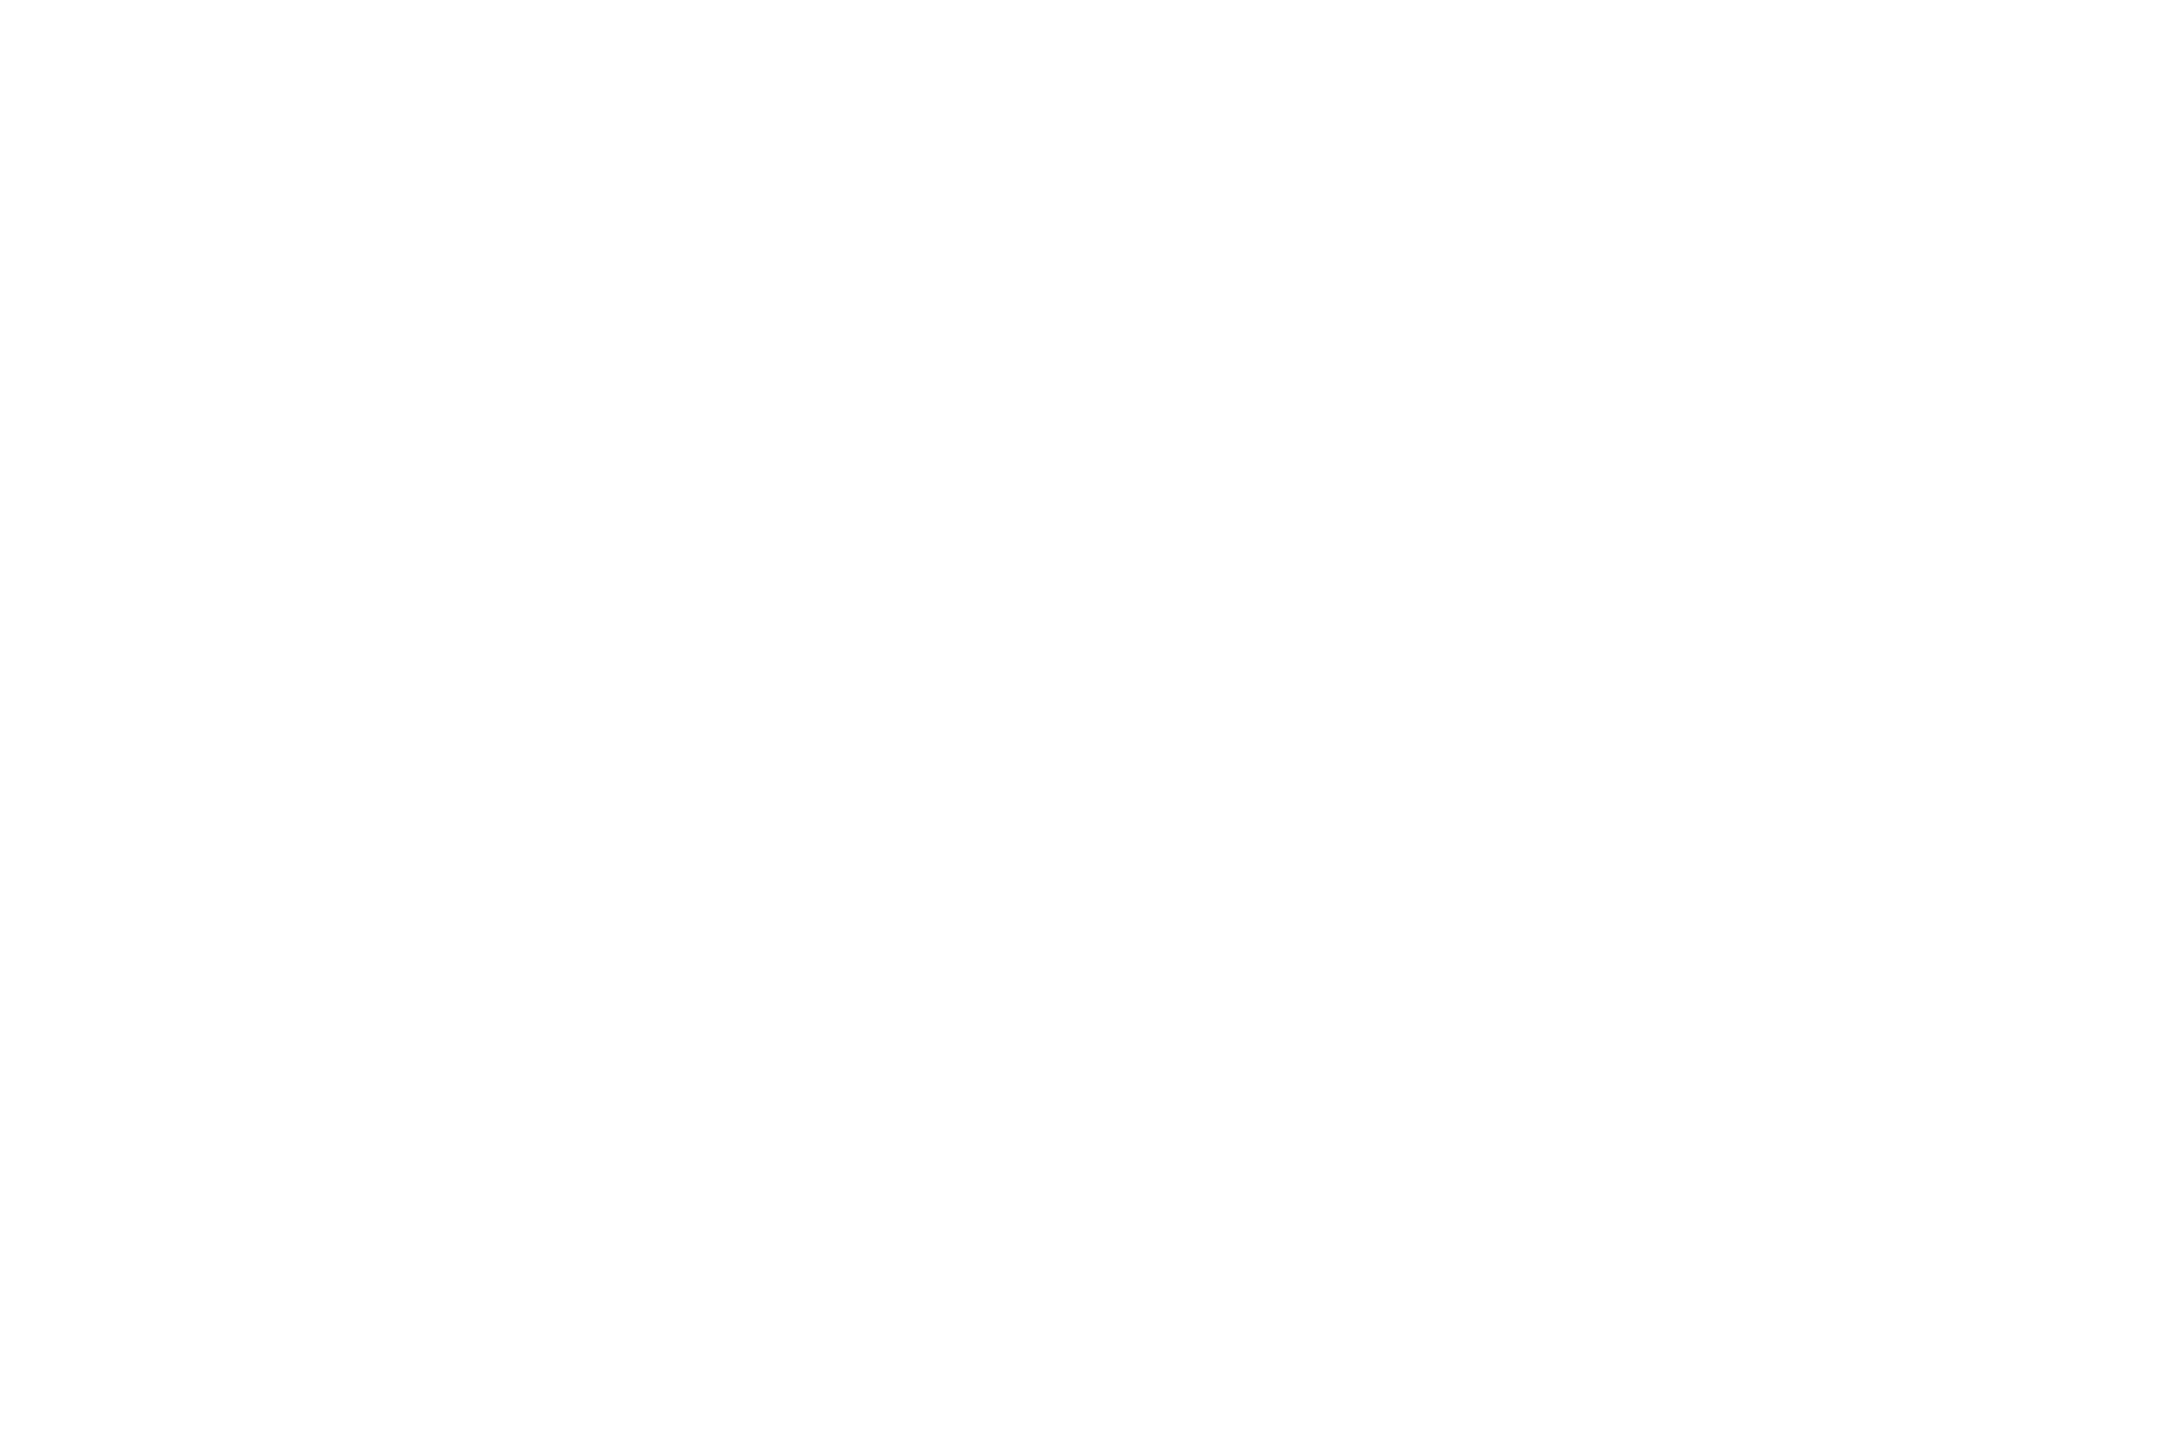

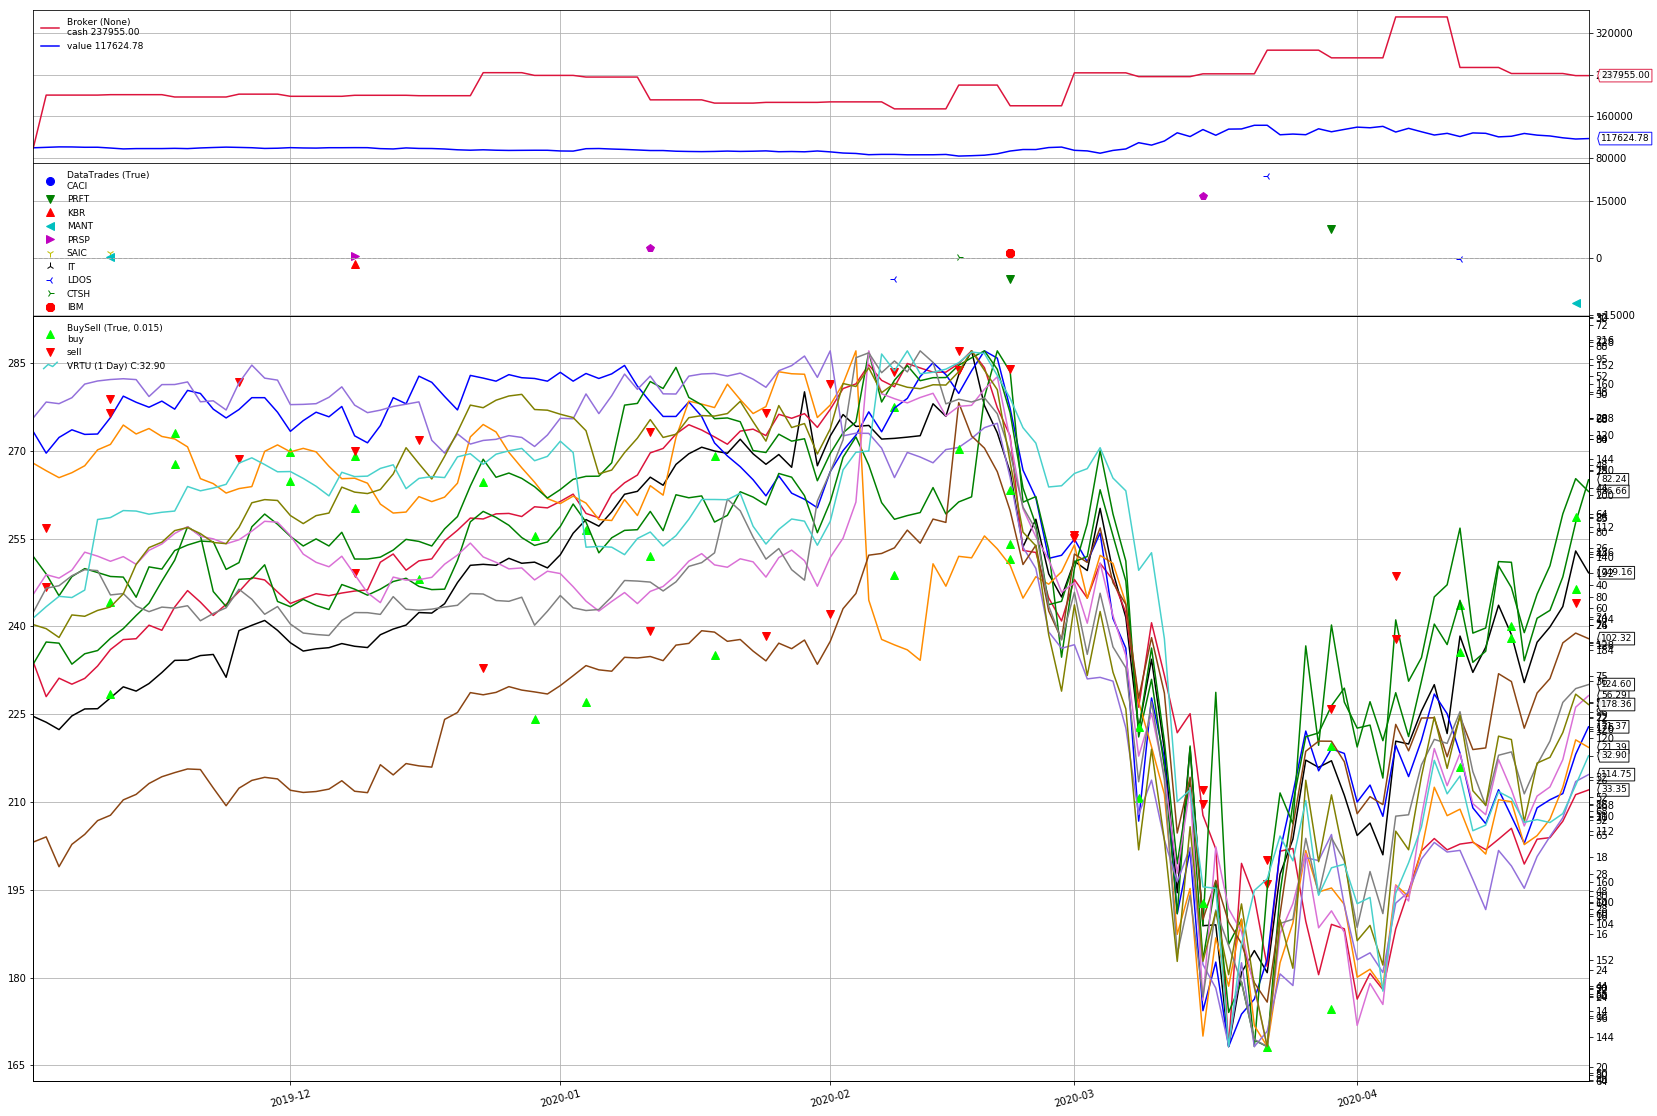

In [173]:
plt.rcParams['figure.figsize'] = [24, 16]
cerebro.plot(volume=False)
plt.savefig("C:/Users/z/Desktop/FIN580 PYTHON/backtrader.jpg")